# 主成分分析
- 教師なし学習の一つ
  - ラベルなしでデータの傾向を掴める
- つぎのような用途で用いられる
  - 次元削減
  - 可視化
  - ノイズ除去
  - 特徴の取り出しなどの特徴エンジニアリング

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## PCAの紹介

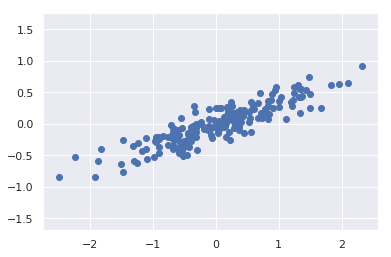

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

線形回帰などではxの値からyの値を予測することを行っていたが、PCAではxとyの間の関係性に関して学習する。

PCAではデータの主要な軸のリストを探すことで関係性を定量化する。そしてその軸はデータセットを説明するのに使われる。

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


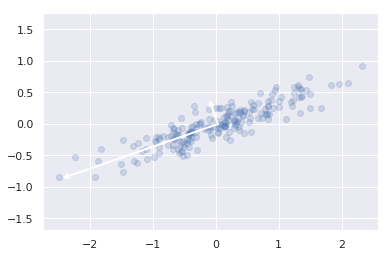

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

個のベクトルはデータの主要な軸を表し、ベクトルの長さはどれだけその軸がデータを説明するのに重要かを示す。厳密にはそれは軸に対して射影した時のデータのばらつきの平均である。

## より数学的な説明
ここでは2次元$x^1, x^2$で考える。データの特徴を表す指標Zを考える。Zは重みwを使用して、

$$ Z = w_1 x^1 + w_2 x^2 $$

ただし、

$$ \sum w_j^2 = 1 $$

とする。

このZの分散VはZの平均を$\overline{Z} =  w_1 \overline{x^1} + w_2 \overline{x^2}$とすると、

$$ V = \frac{1}{n} \sum^{n}_{i-1} (Z_i - \overline{Z})^2 $$

となる。この式を解いていくと、共分散の行列となり、それを$ \sum w_j^2 = 1 $の条件の元で最大化する条件から、Lagrangeの未定乗数法によりとくと

$$
\begin{pmatrix}
s_{11} & s_{12} \\
s_{21} & s_{22}
\end{pmatrix}
\begin{pmatrix}
w_{1} \\
w_{2}
\end{pmatrix}
=
\lambda
\begin{pmatrix}
w_{1} \\
w_{2}
\end{pmatrix}
$$

という固有値問題に帰着する。

この固有値問題の固有ベクトルが主成分の軸となり、固有値の大きさが主成分の分散の大きさとなる。そのため、固有値の大きいものほどそのデータの主成分を表すこととなる。

## PCAでの次元削減

In [7]:
# 2次元から1次元に次元削減
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


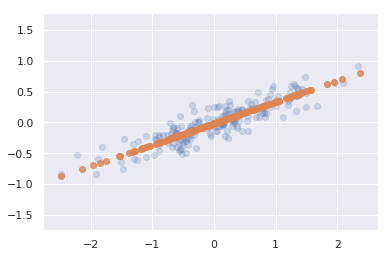

In [8]:
# 次元削減した結果を元の座標系で重ねて表示
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

### 可視化のためのPCA：手書き数字

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

可視化のために64ピクセル（64次元）の特徴点を2次元に射影する。

In [10]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


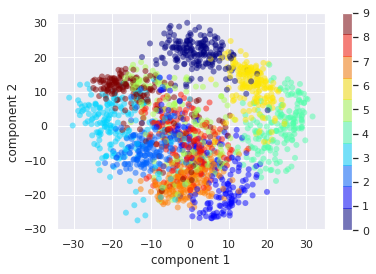

In [11]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### 主成分の数の選択
どれだけの成分があれば、元のデータの特徴を十分に表現できるかを考える。これは各成分の累積寄与率（cumulative explained variance ratio）で計算する。各成分の分散が元のデータの分散の内、どれだけの分散を表現できているかを示すものと考えればよいであろうか。

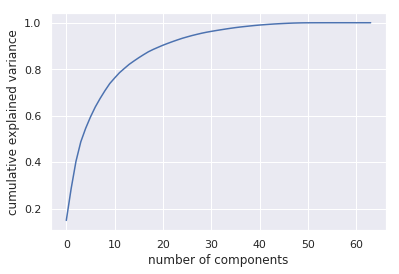

In [12]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

このプロットを見ると、10成分で75%の分散を表現できていることが分かる。50成分もあればほぼ100%再現できている。当然ながら、64成分あれば、完全に再現する。

2成分ではほとんどの情報が失われており、20成分も使えば90%は表現できる。

## ノイズフィルターとしてのPCA
ノイズの影響よりもずっと大きな分散を有する成分は、ノイズによって比較的影響を受けないはずであるというものから来ている。

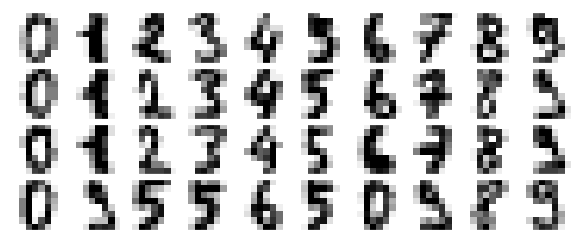

In [13]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

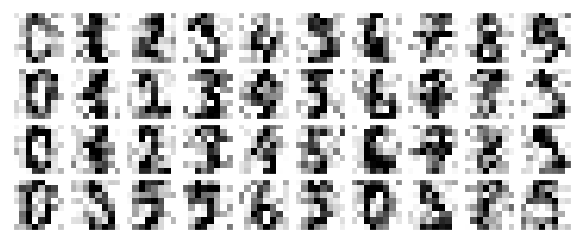

In [14]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

もとのデータの分散の50%を保存するようにPCAを行う。ここでは12成分となっている。

In [15]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

12成分から元の座標系に戻してやる。

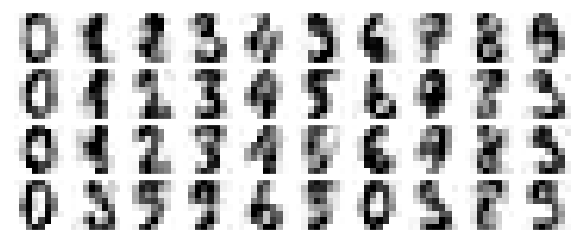

In [16]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

これの特性により、PCAはとても便利な特徴抽出として使える。例えば、非常に高次元のデータの分類の学習により低次元の表現で分類器を学習させれば、自動的に入力のランダムノイズをフィルターしてくれる。

## 例：固有顔

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


データセットが大きい（次元数が大きい）ので`RandomizedPCA`を使用する。これはランダムな手法により通常のPCAより速く計算できる分、正確性を犠牲にしたもの。

In [18]:
from sklearn.decomposition import PCA
pca = PCA(150, svd_solver="randomized")
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

ここで得た主成分のいくつかを可視化してみる。2次元であれば元データに主成分のベクトルを重ねて表示していた。ここでは、主成分のベクトルをイメージとして表示する。この主成分のベクトルは固有ベクトルそのものであるため、これらは固有顔と呼ばれる。つまり、今回は150の成分を取り出したため、この150個の固有顔の重ね合わせで、元の顔を表すこととなる。

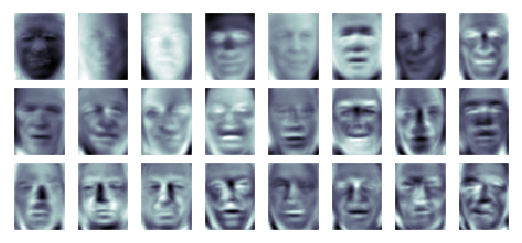

In [19]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

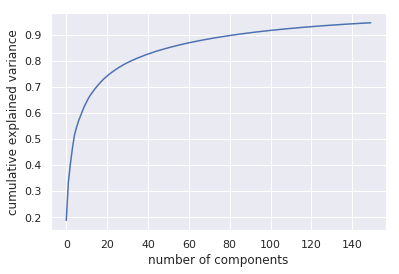

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

150成分で90%異常の分散を占めている。そのため、150成分で十分である。

In [21]:
# Compute the components and projected faces
pca = PCA(150, svd_solver="randomized").fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

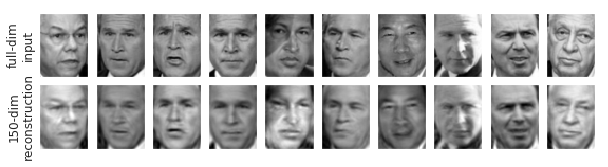

In [22]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

150この成分で十分に元の顔を表現できている。もともとが3000次元のデータであったため、1/20の成分で表現できたこととなる。これにより、学習が効率的に行える。

## 主成分分析のまとめ
どんな高次元のデータであっても、始めにPCAでサンプル点の間の関係性を図示し、データの主要な分散を理解し、潜在的な次元を理解することは助けになる。PCAは全ての高次元データに確実に役に立つわけではないが、高次元データの理解を得る効率的な方法である。

PCAの主な弱点はデータの外れ値に大きく影響される傾向があることである。そのため、多くの堅牢なPCAが開発されており、それらの多くは最初の成分によって役に立たない点を繰り返し破棄することを行う。Scikit-Learnはいくつかの種類のPCAがある。RandomizedなPCAはPCAの`svd_solver`パラメータの設定で利用できる。また、`SparsePCA`は線形回帰の$L_1$正則化の項を利用することで、得られる成分を疎にするPCAである。これはつまり、得られた主成分が元の軸との対応が取りやすいため、人間の解釈がしやすくなる。
（http://www.msi.co.jp/splus/events/student/2012pdf/muc12_yamashita.pdf）